In [1]:
import gensim
import keras
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

Using TensorFlow backend.


In [2]:
path ='../../Datasets/rawData/'
train = pd.read_csv(path + 'train.csv'.format(1))
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
path ='../../Datasets/rawData/'
test = pd.read_csv(path + 'test.csv'.format(1))
test.tail()

,id,comment_text
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
153163,ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."


### Preprocessing

In [4]:
#Breaks down comments into tokens
simple_tokens = train.comment_text.apply(gensim.utils.simple_preprocess)
simple_tokens.head()

0    [explanation, why, the, edits, made, under, my...
1    [aww, he, matches, this, background, colour, s...
2    [hey, man, really, not, trying, to, edit, war,...
3    [more, can, make, any, real, suggestions, on, ...
4    [you, sir, are, my, hero, any, chance, you, re...
Name: comment_text, dtype: object

In [5]:
#Detecting common phrases and multiword expressions
phrases = gensim.models.phrases.Phrases(simple_tokens)
tokenizer = gensim.models.phrases.Phraser(phrases)
tokenized_text = list(tokenizer[simple_tokens])

In [6]:
type(phrases)

gensim.models.phrases.Phrases

In [7]:
type(tokenized_text)

list

In [8]:
tokenized_text[0]

['explanation',
 'why',
 'the',
 'edits',
 'made',
 'under',
 'my',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'were',
 'reverted',
 'they_weren',
 'vandalisms',
 'just',
 'closure',
 'on',
 'some',
 'gas',
 'after',
 'voted',
 'at',
 'new_york',
 'dolls',
 'fac',
 'and',
 'please',
 'don',
 'remove',
 'the',
 'template',
 'from',
 'the',
 'talk_page',
 'since',
 'retired',
 'now']

In [9]:
corpus_dict = gensim.corpora.dictionary.Dictionary(tokenized_text)
type(corpus_dict)

gensim.corpora.dictionary.Dictionary

In [10]:
TARGET_CLASSES = train.columns[1:]
targets = train[TARGET_CLASSES].values
type(targets)

numpy.ndarray

In [11]:
targets

array([["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
        0, 0, ..., 0, 0, 0],
       ["D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
        0, 0, ..., 0, 0, 0],
       ["Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
        0, 0, ..., 0, 0, 0],
       ...,
       ['Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
        0, 0, ..., 0, 0, 0],
       ['And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
   

### Tokens per Comment

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

(0, 400)

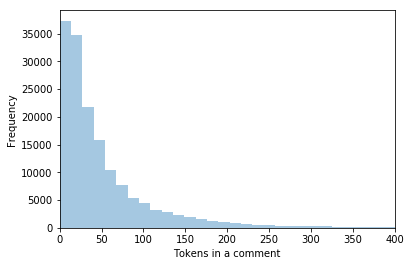

In [13]:
sns.distplot([len(doc) for doc in tokenized_text], bins=100, kde=False, label='Number of tokens per comment.')
plt.xlabel("Tokens in a comment")
plt.ylabel("Frequency")
plt.xlim((0, 400))

### Training Word2Vec on Comments

In [14]:
word2vec = gensim.models.word2vec.Word2Vec(tokenized_text, window=5, size=100, min_count=2, workers=6)
word2vec.wv.most_similar('citation')

[('reference', 0.8310039043426514),
 ('source', 0.7699364423751831),
 ('footnote', 0.7627838850021362),
 ('citations', 0.7599382400512695),
 ('ref', 0.7529930472373962),
 ('references', 0.7518805265426636),
 ('verification', 0.7486398816108704),
 ('secondary_source', 0.720565915107727),
 ('quote', 0.7032634019851685),
 ('quotation', 0.7008849382400513)]

In [15]:
word2vec.wv.most_similar('stupid')

[('dumb', 0.8559213876724243),
 ('lazy', 0.7967990636825562),
 ('retarded', 0.7940258979797363),
 ('pathetic', 0.7768384218215942),
 ('crazy', 0.7577334046363831),
 ('fucking', 0.7403896450996399),
 ('silly', 0.7272301316261292),
 ('funny', 0.726997435092926),
 ('an_idiot', 0.722550630569458),
 ('bullshit', 0.7187906503677368)]

### Model based on Word2Vec

In [16]:
features = np.zeros((len(tokenized_text), word2vec.vector_size))
type(features)

numpy.ndarray

In [18]:
features.shape

(159571, 100)

In [19]:
for i, tokens in enumerate(tokenized_text):
    tokens = [t for t in tokens if t in word2vec.wv.vocab]
    if tokens:
        features[i, :] = np.mean([word2vec.wv[t] / word2vec.wv.vocab[t].count for t in tokens], axis=0)

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(word2vec.vector_size,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.fit(features, targets, epochs=10, validation_split=0.1)  ##error with String conversion

### Sequential model

In [23]:
# Note: shifting indices by 1 as index 0 will be used for padding.
docs = [[idx + 1 for idx in corpus_dict.doc2idx(doc)]  for doc in tokenized_text]

In [24]:
MAX_SEQ_LEN = 50
padded_docs = keras.preprocessing.sequence.pad_sequences(docs, maxlen=MAX_SEQ_LEN, truncating='post', value=0)

In [25]:
max_idx = max(c for d in docs for c in d)
max_idx

185872

In [26]:
embeddings = np.array([np.random.normal(size=word2vec.vector_size)]+ # for the '0' padding word
                      [word2vec.wv[corpus_dict[idx]]
                      if corpus_dict[idx] in word2vec.wv.vocab
                      else np.random.normal(size=word2vec.vector_size)
                      for idx in range(max_idx)])

### LSTM

In [28]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.25))
model.add(LSTM(256, recurrent_initializer='identity'))   ##Identity matrix dimension error
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid'))
model.compile('rmsprop', 'binary_crossentropy')

In [30]:
model.fit(padded_docs, targets, batch_size=256, epochs=10, validation_split=0.1)   ##Identity matrix dimension error

### CNN

In [31]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPool1D, Flatten, BatchNormalization

model = Sequential()
model.add(Embedding(max_idx + 1, word2vec.vector_size, input_length=MAX_SEQ_LEN))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(52, 5, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Convolution1D(128, 3, padding='same',
                        kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(MaxPool1D())
model.add(Flatten())
model.add(Dense(len(TARGET_CLASSES), activation='sigmoid',
                kernel_regularizer=keras.regularizers.l2(0.02)))
model.compile(Adam(0.001), 'binary_crossentropy')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [33]:
model.fit(padded_docs, targets, batch_size=512, epochs=20, validation_split=0.1) ##could not convert string to float error